In [1]:
%matplotlib inline


import os
import json
import pandas as pd
from glob import glob
from tqdm import tqdm
from pathlib import Path
from joblib import Parallel, delayed
from dotenv import load_dotenv, find_dotenv

import matplotlib.pyplot as plt


load_dotenv(find_dotenv())

True

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *
from data.geo_utils import canonicalize_dataframe_geographies

In [3]:
API_KEY = os.environ.get('GMAPS_KEY', '')

In [4]:
def standardize_columns(df):
    df.columns = ['admin2', 'admin1', 'alpha-3']
    df.loc[:, 'alpha-3'] = df['alpha-3'].str.strip()
    return df

def add_country_names(df, iso):
    wanted = iso[['alpha-2', 'name']].rename(columns={'name': 'country'})
    df = df.join(wanted, on='alpha-3')
    return df.rename(columns=lambda c: c.replace('-', ''))

def add_provenance(df, name):
    df = df.reset_index().rename(columns={'index': 'idx'})
    df['provenance'] = name
    df['provenance'] = df.provenance + df.idx.astype(str)
    return df.drop('idx', axis=1).set_index('provenance')

def to_strings(df):
    series = df.apply(_join_row, axis=1)
    return series.drop_duplicates().values.tolist()

def get_search_string(row):
    print(row)
    return ', '.join([row['admin1'], row['admin2']])

In [5]:
ISO = Path('..')/'data'/'external'/'iso-codes.csv'
# this is tricksy because Namibia's alpha-2 is "NA" which gets read as NaN by default
iso = pd.read_csv(ISO, na_values=[], keep_default_na=False).set_index('alpha-3')

WHO = Path('..')/'data'/'interim'/'calc_cols_added.csv'
who = pd.read_csv(WHO, index_col=0).pipe(add_provenance, 'who')
vac = (who[['Admin1', 'Admin2', 'Iso Code']]
       .fillna('')
       .pipe(standardize_columns)
       .pipe(add_country_names, iso)
       .drop_duplicates())

NASA = Path('..')/'data'/'interim'/'external-processed/admin_population_nasa.csv'
nasa = pd.read_csv(NASA).pipe(add_provenance, 'nasa')
pop = (nasa[['NAME1', 'NAME2', 'ISOALPHA']]
       .fillna('')
       .pipe(standardize_columns)
       .pipe(add_country_names, iso)
       .drop_duplicates())

In [6]:
pop.size, vac.size

(211150, 114435)

In [7]:
who.head()

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
provenance,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,51.801245,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth
who1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,94.674670,4354.088093,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth
who2,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aaqcha,1.0,5674.0,NaN,72.116489,4091.889607,Aaqcha,afghanistan,1,BCG,BCG,1st_birth
who3,AFG,Afghanistan,EMRO,2016,BCG,NaN,Acheen,1.0,4846.0,NaN,35.203626,1705.967701,Acheen,afghanistan,1,BCG,BCG,1st_birth
who4,AFG,Afghanistan,EMRO,2016,BCG,NaN,Adraskan,1.0,3557.0,NaN,81.468327,2897.828383,Adraskan,afghanistan,1,BCG,BCG,1st_birth


In [8]:
who.tail()

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
provenance,,,,,,,,,,,,,,,,,,
who178323,PRT,Portugal,EURO,2016,MCV2,Algarve,NaN,1.0,4042.0,NaN,91.5,3698.430,Algarve,portugal,1,Measles,MCV2,NaN
who178324,PRT,Portugal,EURO,2016,MCV2,Lisboa e Vale do Tejo,NaN,1.0,32722.0,NaN,91.7,30006.074,Lisboa e Vale do Tejo,portugal,1,Measles,MCV2,NaN
who178325,PRT,Portugal,EURO,2016,MCV2,Madeira,NaN,1.0,1860.0,NaN,97.7,1817.220,Madeira,portugal,1,Measles,MCV2,NaN
who178326,PRT,Portugal,EURO,2016,MCV2,Potugal Centro,NaN,1.0,11986.0,NaN,96.0,11506.560,Potugal Centro,portugal,1,Measles,MCV2,NaN
who178327,PRT,Portugal,EURO,2016,MCV2,Portugal Norte,NaN,1.0,27766.0,NaN,97.4,27044.084,Portugal Norte,portugal,1,Measles,MCV2,NaN


In [9]:
df = pd.concat([vac, pop]).sort_values(['country', 'admin1', 'admin2'])
df.head(20)

,admin2,admin1,alpha3,alpha2,country
provenance,,,,,
who0,,Aab Band,AFG,AF,Afghanistan
who1,,Aab Kamari,AFG,AF,Afghanistan
who2,,Aaqcha,AFG,AF,Afghanistan
nasa162,Ghazni,Ab Band,AFG,AF,Afghanistan
nasa83,Badghis,Ab Kamari,AFG,AF,Afghanistan
who3,,Acheen,AFG,AF,Afghanistan
nasa325,Nangarhar,Acheen,AFG,AF,Afghanistan
who4,,Adraskan,AFG,AF,Afghanistan
nasa204,Hirat,Adraskan,AFG,AF,Afghanistan


In [10]:
OUTPUT_DIR = Path('..')/'data'/'geocode'
#geocoder = GoogleV3(api_key=API_KEY)

def _geocode(search_string, alpha2, filename):
    !http get https://maps.googleapis.com/maps/api/geocode/json key=="$API_KEY" address=="$search_string" components=="country:$alpha2" > $filename

def get_filename(index):
    return OUTPUT_DIR/f"{index}.json"

def geocode_if_not_already_here(row):
    index, admin2, admin1, _, alpha2, _ = row
    filename = get_filename(index)
    if os.path.exists(filename):
        return False
    search_string = f"{admin2}, {admin1}" if admin2 else admin1
    _geocode(search_string, alpha2, filename)
    return True

In [11]:
rows = list(df.itertuples(name=None))
r = Parallel(n_jobs=26, verbose=5)(delayed(geocode_if_not_already_here)(row) for row in rows)

[Parallel(n_jobs=26)]: Done  20 tasks      | elapsed:    0.0s


/bin/sh: -c: line 0: unexpected EOF while looking for matching ``'
/bin/sh: -c: line 1: syntax error: unexpected end of file
/bin/sh: -c: line 0: unexpected EOF while looking for matching ``'
/bin/sh: -c: line 1: syntax error: unexpected end of file
/bin/sh: -c: line 0: unexpected EOF while looking for matching ``'
/bin/sh: -c: line 1: syntax error: unexpected end of file
/bin/sh: -c: line 0: unexpected EOF while looking for matching ``'
/bin/sh: -c: line 1: syntax error: unexpected end of file
/bin/sh: -c: line 0: unexpected EOF while looking for matching `''
/bin/sh: -c: line 1: syntax error: unexpected end of file


[Parallel(n_jobs=26)]: Done 10168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=26)]: Done 65117 out of 65117 | elapsed:    0.9s finished


In [25]:
from unidecode import unidecode

def read_geocoded_results():
    files = glob('../data/geocode/*.json')
    canonicals = []
    for filepath in files:
        _, filename = os.path.split(filepath)
        index = filename.split('.')[0]
        with open(filepath, 'r') as f:
            try:
                payload = json.load(f)
            except json.JSONDecodeError:
                print('problem:', index)
        payload.update({'provenance': index})
        canonicals.append(payload)
    return canonicals

def extract_canonical_location_info(item):
    place_id, google_admin_1, google_admin_2 = ['not_found']*3
    
    if item['results']:
        place_id = item['results'][0]['place_id']
        
        for ac in item['results'][0]['address_components']:
            if 'administrative_area_level_1' in ac['types']:
                google_admin_1 = unidecode(ac['long_name'])
            elif 'administrative_area_level_2' in ac['types']:
                google_admin_2 = unidecode(ac['long_name'])
    
    return {'provenance': item['provenance'],
            'google_admin_1': google_admin_1,
            'google_admin_2': google_admin_2,
            'place_id': place_id}

def canonical_df_from_geocoded_results(canonicals):
    generator = (extract_canonical_location_info(index) for index in canonicals)
    return pd.DataFrame.from_records(generator).set_index('provenance')

In [26]:
canonicals = read_geocoded_results()
canonicals[0]

problem: nasa12615
problem: nasa12361
problem: nasa12805
problem: nasa12872
problem: nasa12424
problem: nasa12077
problem: nasa12533
problem: nasa12315
problem: nasa11955
problem: nasa12565


{'provenance': 'nasa32369',
 'results': [{'address_components': [{'long_name': 'Chagang',
     'short_name': 'Chagang',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'North Korea',
     'short_name': 'KP',
     'types': ['country', 'political']}],
   'formatted_address': 'Chagang, North Korea',
   'geometry': {'bounds': {'northeast': {'lat': 41.80851699999999,
      'lng': 127.495489},
     'southwest': {'lat': 39.991374, 'lng': 125.4156571}},
    'location': {'lat': 40.7202809, 'lng': 126.5621137},
    'location_type': 'APPROXIMATE',
    'viewport': {'northeast': {'lat': 41.80851699999999, 'lng': 127.495489},
     'southwest': {'lat': 39.991374, 'lng': 125.4156571}}},
   'partial_match': True,
   'place_id': 'ChIJO9FvgPpMLV4R8LZwi9Ic_YA',
   'types': ['administrative_area_level_1', 'political']}],
 'status': 'OK'}

In [27]:
location_df = canonical_df_from_geocoded_results(canonicals)

In [28]:
location_df.google_admin_2.describe()

count         65112
unique        17083
top       not_found
freq          30407
Name: google_admin_2, dtype: object

In [29]:
who[['Country Name', 'Admin1', 'Admin2']].drop_duplicates().shape

(22887, 3)

In [30]:
location_df.head(2)

,google_admin_1,google_admin_2,place_id
provenance,,,
nasa32369,Chagang,not_found,ChIJO9FvgPpMLV4R8LZwi9Ic_YA
nasa19039,Mie Prefecture,not_found,ChIJW5-GzYEPBGAReKwxhFv9euQ


In [31]:
who.head()

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
provenance,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,51.801245,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth
who1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,94.674670,4354.088093,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth
who2,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aaqcha,1.0,5674.0,NaN,72.116489,4091.889607,Aaqcha,afghanistan,1,BCG,BCG,1st_birth
who3,AFG,Afghanistan,EMRO,2016,BCG,NaN,Acheen,1.0,4846.0,NaN,35.203626,1705.967701,Acheen,afghanistan,1,BCG,BCG,1st_birth
who4,AFG,Afghanistan,EMRO,2016,BCG,NaN,Adraskan,1.0,3557.0,NaN,81.468327,2897.828383,Adraskan,afghanistan,1,BCG,BCG,1st_birth


In [32]:
iso.head()

,name,alpha-2,country-code,iso_3166-2,region,sub-region,region-code,sub-region-code
alpha-3,,,,,,,,
AFG,Afghanistan,AF,4,ISO 3166-2:AF,Asia,Southern Asia,142,034
ALA,Åland Islands,AX,248,ISO 3166-2:AX,Europe,Northern Europe,150,154
ALB,Albania,AL,8,ISO 3166-2:AL,Europe,Southern Europe,150,039
DZA,Algeria,DZ,12,ISO 3166-2:DZ,Africa,Northern Africa,002,015
ASM,American Samoa,AS,16,ISO 3166-2:AS,Oceania,Polynesia,009,061


In [33]:
# !http get https://maps.googleapis.com/maps/api/geocode/json key=="$API_KEY" address=="Argoba Liyu" components=="country:ET"

In [34]:
# cs = ['Iso Code', 'Admin1', 'Admin2', 'google_admin_1', 'google_admin_2', 'place_id']
# merged[cs].replace({None: np.nan}).drop_duplicates().dropna(subset=['google_admin_1', 'google_admin_2'])

In [37]:
merged = (who.join(location_df, how='left')
             .sort_values(['Country Name', 'Admin1', 'Admin2', 'place_id']))
 
merged.loc[:, ['google_admin_1', 'google_admin_2', 'place_id']] = \
    merged.loc[:, ['google_admin_1', 'google_admin_2', 'place_id']].fillna(method='ffill')

merged.head(100)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,...,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,google_admin_1,google_admin_2,place_id
provenance,,,,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,...,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who1151,AFG,Afghanistan,EMRO,2016,Pol3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,Polio,Pol3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who175898,AFG,Afghanistan,EMRO,2016,HepB3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,HepB,HepB3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who176254,AFG,Afghanistan,EMRO,2016,Hib3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,H. influenzae,Hib3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who176610,AFG,Afghanistan,EMRO,2016,PCV1,NaN,Aab Band,2.0,1176.0,NaN,...,803.109813,Aab Band,afghanistan,1,Pneumococcal,PCV1,2nd_6wks_2mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who176966,AFG,Afghanistan,EMRO,2016,PCV2,NaN,Aab Band,2.0,1176.0,NaN,...,656.089710,Aab Band,afghanistan,1,Pneumococcal,PCV2,3rd_10wks_4mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who177322,AFG,Afghanistan,EMRO,2016,PCV3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,Pneumococcal,PCV3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who177678,AFG,Afghanistan,EMRO,2016,MCV1,NaN,Aab Band,2.0,1176.0,NaN,...,618.084514,Aab Band,afghanistan,1,Measles,MCV1,5th_9mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who178034,AFG,Afghanistan,EMRO,2016,MCV2,NaN,Aab Band,2.0,1176.0,NaN,...,487.066599,Aab Band,afghanistan,1,Measles,MCV2,NaN,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4


In [38]:
merged.to_csv(Path("../data/interim/who_subnational_with_geocodes.csv"))

In [39]:
wb = pd.read_csv(Path("../data/interim/external-processed/country_world_bank_indicators.csv"), index_col=0)

In [40]:
nasa.head()

,ISOALPHA,NAME1,NAME2,UN_2015_E
provenance,,,,
nasa0,ABW,Noord/ Tanki Leendert,Alto Vista,5503.0
nasa1,ABW,Noord/ Tanki Leendert,Moko/Tanki Flip,4071.0
nasa2,ABW,Noord/ Tanki Leendert,Noord Other,0.0
nasa3,ABW,Noord/ Tanki Leendert,Palm Beach/Malmok,5499.0
nasa4,ABW,Noord/ Tanki Leendert,Tanki Leendert,3958.0


In [41]:
nasa = nasa.merge(wb[['crude_birth_rate_2016', 'infant_mortality_rate_2016']], right_index=True, left_on='ISOALPHA')

nasa['est_denom_1'] = nasa.UN_2015_E * nasa.crude_birth_rate_2016 / 1000
nasa['est_denom_2'] = nasa.est_denom_1 * (1000 - nasa.infant_mortality_rate_2016) / 1000

In [42]:
nasa_places_and_estimates = (nasa.join(location_df)
                                 .groupby('place_id')[['est_denom_1', 'est_denom_2', 'ISOALPHA']]
                                 .agg({'est_denom1': np.sum, 'est_denom_2': np.sum, 'ISOALPHA': 'first'}))

nasa_places_and_estimates = nasa_places_and_estimates.loc[:, 'ISOALPHA']

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [43]:
who_places_and_estimates = merged.groupby(['place_id', 'DenomType']).Denominator.sum().unstack()
who_places_and_estimates.head(2)

DenomType,1.0,2.0,3.0,5.0
place_id,,,,
ChIJ--2uE4OoPkARWEh2fILMlzU,14944.0,NaN,NaN,NaN
ChIJ--A3JakhkZQRz_w9lSHGwdA,NaN,68.0,NaN,34.0


In [44]:
code_to_name = (who[['Iso Code', 'Country Name']].drop_duplicates()
                                                    .set_index('Iso Code')
                                                    .to_dict()['Country Name'])


In [45]:
diffs = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .drop_duplicates()
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2)))

diffs[diffs.ISOALPHA == 'RUS']

,est_denom_1,est_denom_2,ISOALPHA,1.0,2.0,3.0,5.0,pct_diff1,pct_diff2,pct_diff
place_id,,,,,,,,,,
ChIJAS4yugIKt0YRizHZ99vDWRY,5157.4341,5123.395035,RUS,100984.0,NaN,NaN,NaN,18.580279,NaN,18.580279
ChIJDU8FOJPwMUER22dHyN39iUM,858.1293,852.465647,RUS,58296.0,NaN,NaN,NaN,66.933818,NaN,66.933818
ChIJHyMdKZGKqFwRLuE1LERdadI,12737.4765,12653.409155,RUS,271704.0,NaN,NaN,NaN,20.331070,NaN,20.331070
ChIJI_OrHRUvSEERzelNFHeHaD0,6799.1462,6754.271835,RUS,86608.0,NaN,NaN,NaN,11.738070,NaN,11.738070
ChIJO4mGd7lC8EARgJXxg6WjAgE,1706.6161,1695.352434,RUS,524504.0,NaN,NaN,NaN,306.335669,NaN,306.335669
ChIJXyfDUqZgskYRJA-YkhpiTE8,7613.6648,7563.414612,RUS,111920.0,NaN,NaN,NaN,13.699885,NaN,13.699885
ChIJ_0EiPofU50IR1TtsjXACf-4,329.5341,327.359175,RUS,211240.0,NaN,NaN,NaN,640.026225,NaN,640.026225
ChIJc7c_RiwJNEERSxxmDujG1aA,6436.8675,6394.384174,RUS,100464.0,NaN,NaN,NaN,14.607592,NaN,14.607592
ChIJc_dpU4GNHUMRPFMGiXZtmN8,1546.5506,1536.343366,RUS,264768.0,NaN,NaN,NaN,170.199054,NaN,170.199054


In [46]:
to_plot = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .groupby('ISOALPHA')
                                    .sum()
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2)))

to_plot = to_plot.pct_diff.sort_values(ascending=False)

to_plot.name = 'nasa_pct_diff_of_agg'
to_plot.to_frame().to_csv(Path('../data/processed/scores/country-nasa_pct_diff_of_agg.csv'))
        

# to_plot.rename(index=code_to_name, inplace=True)

# PLOT_LIM = 64
# FS=10

# with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
#     labeled_bar(ax,
#                 to_plot.head(PLOT_LIM).sort_values(),
#                 font_size=FS,
#                 horizontal=True,
#                 label_formatter=pct_func_formatter(),
#                 color=PALETTE['green']
#                )
    
    
#     ax.set_ylabel('')
#     ax.set_title('Percent Error Between GPW and WHO subnational estimates'.format(PLOT_LIM))

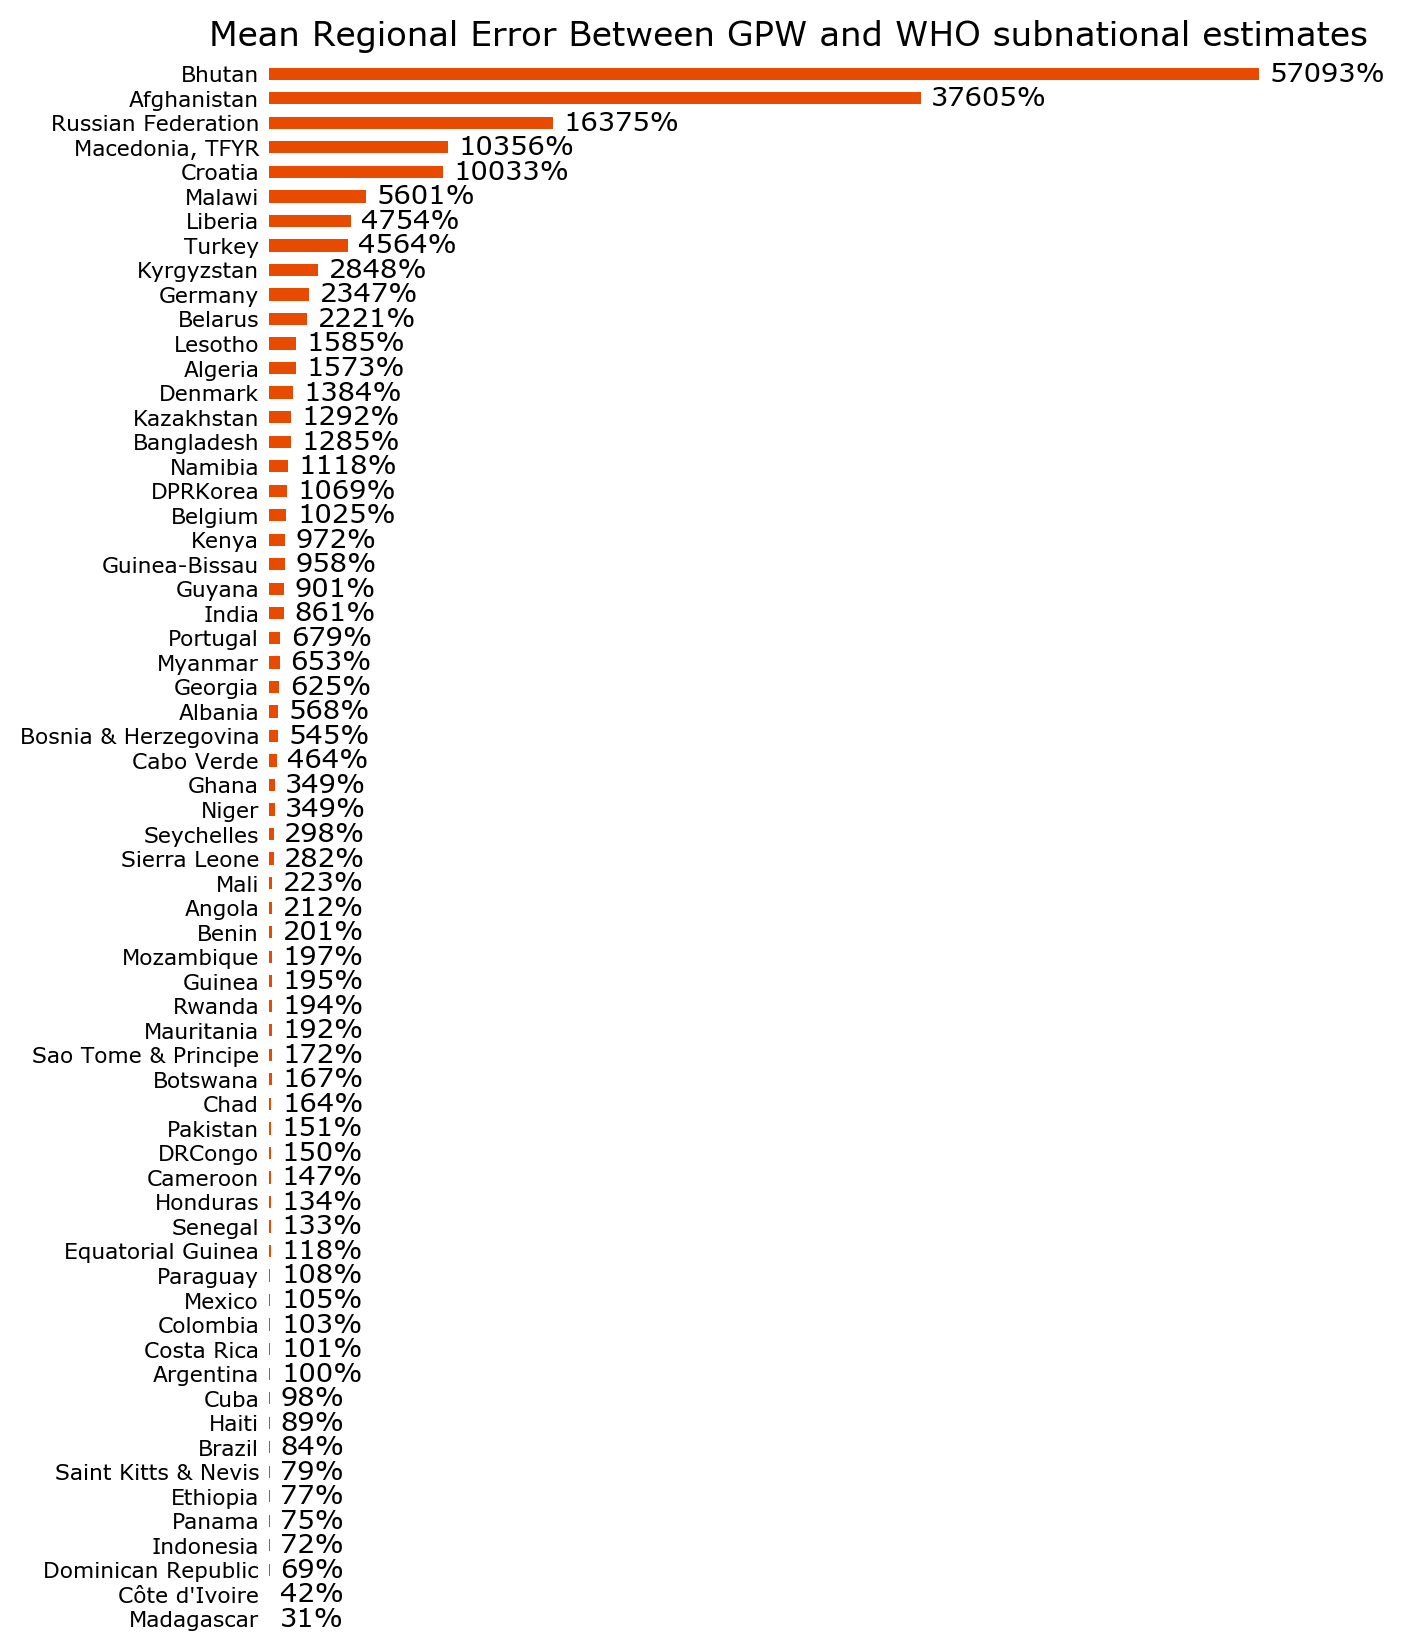

In [47]:
to_plot = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2))
                                    .assign(diff1=lambda x: np.abs(x[1.0] - x.est_denom_1))
                                    .assign(diff2=lambda x: np.abs(x[2.0] - x.est_denom_2))
                                    .assign(diff=lambda x: np.where(pd.notnull(x.diff1), x.diff1, x.diff2))
                                    .replace({np.inf: np.nan})
                                    .dropna(subset=['pct_diff']) 
                                    .groupby('ISOALPHA')
                                    .pct_diff
                                    .mean()
                                    .sort_values(ascending=False))

to_plot.name = 'nasa_mean_pct_diff'
to_plot.to_frame().to_csv(Path('../data/processed/scores/country-nasa_mean_pct_diff.csv'))

to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 64
FS=10

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Regional Error Between GPW and WHO subnational estimates'.format(PLOT_LIM))

In [ ]:
to_plot = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2))
                                    .assign(diff1=lambda x: np.abs(x[1.0] - x.est_denom_1))
                                    .assign(diff2=lambda x: np.abs(x[2.0] - x.est_denom_2))
                                    .assign(diff=lambda x: np.where(pd.notnull(x.diff1), x.diff1, x.diff2))
                                    .replace({np.inf: np.nan})
                                    .dropna(subset=['diff'])
                                    .groupby('ISOALPHA')
                                    .diff
                                    .mean()
                                    .sort_values(ascending=False))

to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 64
FS=10

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=comma_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=comma_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Absolute Error Between GPW and WHO subnational estimates'.format(PLOT_LIM))

In [ ]:
# to_plot = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
#                                     .assign(diff1=lambda x: np.abs(x[1.0] - x.est_denom_1))
#                                     .assign(diff2=lambda x: np.abs(x[2.0] - x.est_denom_2))
#                                     .assign(abs_diff=lambda x: np.where(pd.notnull(x.diff1), x.diff1, x.diff2))
#                                     .assign(total_denom=lambda x: np.where(pd.notnull(x.est_denom_1), x.est_denom_1, x.est_denom_2))
#                                     .replace({np.inf: np.nan})
#                                     .dropna(subset=['abs_diff', 'total_denom'])
#                                     .groupby('ISOALPHA')
#                                     .apply(lambda x: x.abs_diff.sum() / x.total_denom.sum())
#                                     .sort_values(ascending=False))

# to_plot

# to_plot.rename(index=code_to_name, inplace=True)

# PLOT_LIM = 64
# FS=10

# with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
#     labeled_bar(ax,
#                 to_plot.head(PLOT_LIM).sort_values(),
#                 font_size=FS,
#                 horizontal=True,
#                 label_formatter=pct_func_formatter(),
#                 color=PALETTE['red']
#                )
    
    
#     ax.set_ylabel('')
#     ax.set_title('Percent Error Between GPW and WHO subnational estimates'.format(PLOT_LIM))

In [ ]:
dr_check = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner')
                                    .assign(pct_diff1=lambda x: np.abs(x[1.0] - x.est_denom_1) / x.est_denom_1)
                                    .assign(pct_diff2=lambda x: np.abs(x[2.0] - x.est_denom_2) / x.est_denom_2)
                                    .assign(pct_diff=lambda x: np.where(pd.notnull(x.pct_diff1), x.pct_diff1, x.pct_diff2))
                                    .assign(diff1=lambda x: np.abs(x[1.0] - x.est_denom_1))
                                    .assign(diff2=lambda x: np.abs(x[2.0] - x.est_denom_2))
                                    .assign(diff=lambda x: np.where(pd.notnull(x.diff1), x.diff1, x.diff2))
                                    .replace({np.inf: np.nan}))

dr_check[dr_check.ISOALPHA == 'RWA']

In [ ]:
test = (nasa_places_and_estimates.join(who_places_and_estimates, how='inner'))
test[pd.notnull(test[5.0])].ISOALPHA.value_counts()        


In [ ]:
nasa_places_and_estimates.head()